In [242]:
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
import pandas as pd
import inspect
import urllib.request
import re
from collections import Counter
import string; 

from itertools import combinations, count
from sklearn.mixture import GaussianMixture


# TSP


## Przyklad M1 -- 13 miast

We are given 13 cities in US:

![13 cities in US](https://raw.githubusercontent.com/lorek/datasets/master/tsp_13cities.png)

The distances between each of them (they are numbered somehow) are given in a matrix M (miles?)

In [5]:
M1=np.array([
        [0, 2451, 713, 1018, 1631, 1374, 2408, 213, 2571, 875, 1420, 2145, 1972],
        [2451, 0, 1745, 1524, 831, 1240, 959, 2596, 403, 1589, 1374, 357, 579],
        [713, 1745, 0, 355, 920, 803, 1737, 851, 1858, 262, 940, 1453, 1260],
        [1018, 1524, 355, 0, 700, 862, 1395, 1123, 1584, 466, 1056, 1280, 987],
        [1631, 831, 920, 700, 0, 663, 1021, 1769, 949, 796, 879, 586, 371],
        [1374, 1240, 803, 862, 663, 0, 1681, 1551, 1765, 547, 225, 887, 999],
        [2408, 959, 1737, 1395, 1021, 1681, 0, 2493, 678, 1724, 1891, 1114, 701],
        [213, 2596, 851, 1123, 1769, 1551, 2493, 0, 2699, 1038, 1605, 2300, 2099],
        [2571, 403, 1858, 1584, 949, 1765, 678, 2699, 0, 1744, 1645, 653, 600],
        [875, 1589, 262, 466, 796, 547, 1724, 1038, 1744, 0, 679, 1272, 1162],
        [1420, 1374, 940, 1056, 879, 225, 1891, 1605, 1645, 679, 0, 1017, 1200],
        [2145, 357, 1453, 1280, 586, 887, 1114, 2300, 653, 1272, 1017, 0, 504],
        [1972, 579, 1260, 987, 371, 999, 701, 2099, 600, 1162, 1200, 504, 0],
    ])
 

## Przyklad M2 -- 47 miast

Wczytujemy wieksza M, 47x47

In [187]:
url='https://raw.githubusercontent.com/lorek/datasets/master/att48_d_v2.csv'
df = pd.read_csv(url, index_col=0)
M2=df.to_numpy()


## Przyklad M3 -- sztuczny mieszanka 3 gaussow

In [444]:
N = 250
N1=int(N/3)
Nf=N-2*N1

gr1_mean=np.array([100,600])
gr1_cov = np.array([[6000,1000],[1000,6000]])
pnts=np.random.multivariate_normal(gr1_mean,gr1_cov, N1)
print(pnts.shape)
gr2_mean=np.array([680,1240])
gr2_cov = np.array([[9000,5000],[5000,9000]])
pnts2=np.random.multivariate_normal(gr2_mean,gr2_cov, N1)

pnts=np.concatenate((pnts,pnts2),axis=0)
print(pnts.shape)
gr3_mean=np.array([400,40])
gr3_cov = np.array([[3000,2000],[2000,3000]])
pnts3=np.random.multivariate_normal(gr3_mean,gr3_cov, Nf)

pnts=np.concatenate((pnts,pnts3),axis=0)
print(pnts.shape)

#np.random.shuffle(pnts)

(83, 2)
(166, 2)
(250, 2)


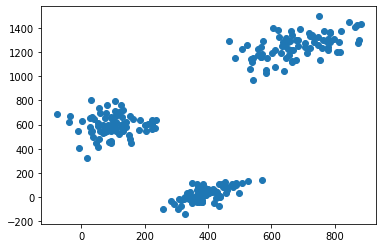

In [445]:

plt.scatter(pnts[:,0], pnts[:,1])

# z powyzszych punktow tworzymy M3

In [446]:
M3=np.zeros((N,N))
for x in np.arange(N):
  for y in np.arange(x+1,N):
    M3[x,y]=np.round(np.sqrt(np.sum((pnts[x,:]-pnts[y,:])**2)),2)
    M3[y,x]=M3[x,y]


**TUTAJ USTALAMY DE FACTO CO TO ZA PRZYKLAD:**




In [447]:
M=M3
n=M.shape[0]

Fix some permutation -- the orderding a salesman visits the cities:

$$f(\sigma)=\sum_{k=1}^{n-1}M(\sigma_k, \sigma_{k+1})+M(\sigma_n,\sigma_1).$$
  We aim at $\textrm{argmin}f(\sigma)$ -- need to come up with some $\pi(\sigma)$, such that 
  $$\sigma^*=\textrm{argmax}_{\sigma} \pi(\sigma),$$

In [448]:
n

250

In [449]:
def calc_dist(M,sigma):
# a function computing total distance of a salesman
# with given M and sigma
# aka f(sigma)
	n=np.shape(sigma)[0];
	fsum=0;
	for i in np.arange(0,n-1):		
		fsum = fsum + M[sigma[i],sigma[i+1]]		
	fsum = fsum + M[sigma[n-1],sigma[0]]
	return fsum

In [450]:
#Try several random permutations:
np.random.seed(1234)
dist_avg=0
nr_iter=10
for i in np.arange(nr_iter):
  sigma=np.random.permutation(n);
  dist = calc_dist(M,sigma)
  print("iter ", i, ", dist = ", dist)
  dist_avg += dist
dist_avg=dist_avg/nr_iter
print("Average dist = ", np.round(dist_avg,2))

iter  0 , dist =  160056.80000000005
iter  1 , dist =  169925.03999999995
iter  2 , dist =  161562.30000000013
iter  3 , dist =  163905.10000000003
iter  4 , dist =  170707.24999999988
iter  5 , dist =  162390.46999999997
iter  6 , dist =  163521.14999999988
iter  7 , dist =  154442.6
iter  8 , dist =  169795.88999999987
iter  9 , dist =  165459.39000000013
Average dist =  164176.6


Mapowanie: pary -> integerow pairs2ints, 
tworzymy ${n\choose 2}$ par (0,1), (0,2),, itd i kazda para (i,j)->k

Mapowanie odwrotne ints2pairs(k)->(i,j)

In [451]:
pairs2ints = dict(zip(combinations(range(n), 2), count()))
ints2pairs = {pairs2ints[k] : k for k in pairs2ints}

In [452]:
print(pairs2ints[(0,1)], pairs2ints[(0,2)], pairs2ints[(5,8)], pairs2ints[(11,12)])


0 1 1237 2684


In [453]:
print(ints2pairs[0],ints2pairs[1],ints2pairs[52],ints2pairs[77])

(0, 1) (0, 2) (0, 53) (0, 78)


In [454]:
n_pairs=len(pairs2ints)

In [455]:
#powinno byc to samo:
print(n_pairs, int(n*(n-1)/2))


31125 31125


In [456]:
distribution_on_pairs_uniform=np.ones(n_pairs)/n_pairs;

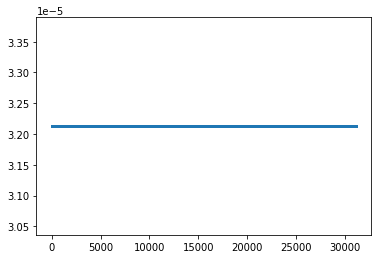

In [457]:
plt.scatter(np.arange(n_pairs),distribution_on_pairs_uniform,s=1)

In [458]:
#przyklad:

nr_rand=np.random.choice(n_pairs,1,p=distribution_on_pairs_uniform)[0]
i,j=ints2pairs[nr_rand]
print("(i,j) = ",i,j)

(i,j) =  58 204


In [459]:
def softmax(x, tau):
    e_x = np.exp(x/tau)
    return e_x / e_x.sum(axis=0)  

def softmax2(x, tau=1):
    e_x = np.exp((x-np.max(x))/tau)
    return e_x / e_x.sum(axis=0)  

1.0

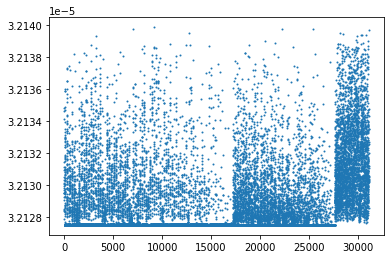

In [464]:
distribution_on_pairs_ver1=np.zeros(n_pairs)
tau= np.mean(M)
for r in np.arange(n_pairs):
  i,j = ints2pairs[r];
  distribution_on_pairs_ver1[r] = np.exp(-M[i,j]/tau)

# softmax

distribution_on_pairs_ver1=softmax2(distribution_on_pairs_ver1,0.1)
distribution_on_pairs_ver1 = distribution_on_pairs_ver1 + np.ones(n_pairs)/n**2
distribution_on_pairs_ver1=softmax2(distribution_on_pairs_ver1)
plt.scatter(np.arange(n_pairs),distribution_on_pairs_ver1,s=1)
np.sum(distribution_on_pairs_ver1)

### The Metropolis algorithm for TSP
start with some random $\sigma$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp


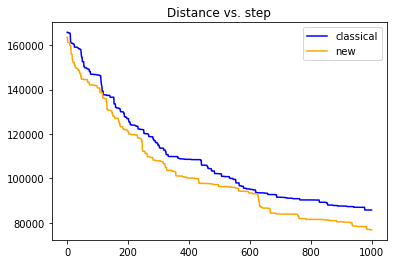

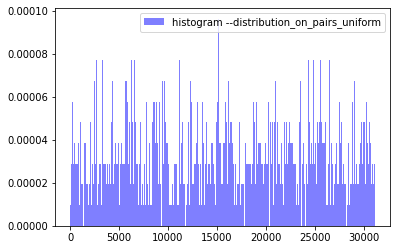

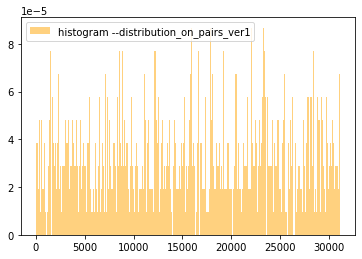

In [462]:
sigma=np.random.permutation(n);
#np.random.seed()

R = 10**3
tau=0.2
#0.02


chosen_r=np.zeros(R)
chosen_r2=np.zeros(R)

# zmienne z 2 w nazwie -- nowe

sigma2=cp.copy(sigma)


y=np.zeros(R)
y2=np.zeros(R)

for k in np.arange(R):  


  
    # classical metropolis, uniform distribution
    nr_rand=np.random.choice(n_pairs,1,p=distribution_on_pairs_uniform)[0]
    chosen_r[k]=nr_rand
    i,j=ints2pairs[nr_rand]    
	
    sigma_candidate=cp.copy(sigma)
    sigma_candidate[[i,j]]=sigma_candidate[[j,i]]
   
    alpha = np.min([1,np.exp((calc_dist(M,sigma)-calc_dist(M,sigma_candidate))/tau)])
 
    if np.random.rand(1)[0]<=alpha:
        sigma=cp.copy(sigma_candidate)

    y[k]=calc_dist(M,sigma)

# NEW
    nr_rand2=np.random.choice(n_pairs,1,p=distribution_on_pairs_ver1)[0]
    chosen_r2[k]=nr_rand2
    i,j=ints2pairs[nr_rand2]    
	
    sigma2_candidate=cp.copy(sigma2)
    sigma2_candidate[[i,j]]=sigma2_candidate[[j,i]]
   
    alpha2 = np.min([1,np.exp((calc_dist(M,sigma2)-calc_dist(M,sigma2_candidate))/tau)])
 
    if np.random.rand(1)[0]<=alpha2:
        sigma2=cp.copy(sigma2_candidate)

    y2[k]=calc_dist(M,sigma2)
    
    

plt.figure(1)
plt.plot(np.arange(R),y, label="classical", color="blue")
plt.plot(np.arange(R),y2, label="new", color="orange")

plt.legend()
plt.title("Distance vs. step")

plt.figure(2)
plt.hist(chosen_r,density=True, bins=300,alpha=0.5, color="blue", label="histogram --distribution_on_pairs_uniform")
plt.legend()
plt.figure(3)
plt.hist(chosen_r2,density=True, bins=300,alpha=0.5, color="orange", label="histogram --distribution_on_pairs_ver1")
plt.legend()
plt.show()


	


In [439]:
np.min(distribution_on_pairs_uniform)


3.21285140562249e-05

In [440]:
np.min(distribution_on_pairs_uniform)-np.max(distribution_on_pairs_uniform)

0.0

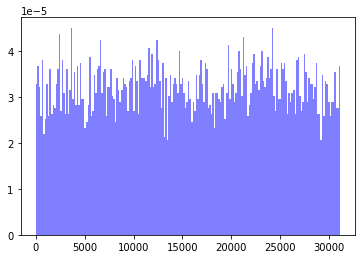

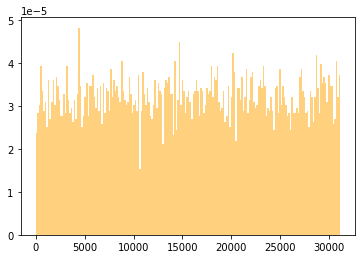

In [443]:
R2=10**4

chs=np.zeros(R2)
chs2=np.zeros(R2)

for k in np.arange(R2):
  nr_rand=np.random.choice(n_pairs,1,p=distribution_on_pairs_uniform)[0]
  chs[k]=nr_rand
  nr_rand2=np.random.choice(n_pairs,1,p=distribution_on_pairs_ver1)[0]
  chs2[k]=nr_rand2

plt.figure(1)
plt.hist(chs,density=True, bins=200,alpha=0.5, color="blue", label="histogram --distribution_on_pairs_uniform");
plt.figure(2)
plt.hist(chs2,density=True, bins=200,alpha=0.5, color="orange", label="histogram --distribution_on_pairs_ver1");
plt.show()
